In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="darkgrid")

In [ ]:
df = pd.read_csv('../data/transform/match_details_transformed.csv')
selected_columns_with_target = [
    'home_avg_goals_scored', 'away_avg_goals_scored', 'home_avg_goals_conceded', 'away_avg_goals_conceded', 'home_wins', 'away_wins', 'home_team_strength', 'away_team_strength', 'weighted_wins_diff', 'home_streak_wins', 'away_streak_wins', 'home_sum_points', 'away_sum_points', 'points_diff', 'win_eachother_home', 'win_eachother_away', 'avg_possession_home', 'avg_possession_away', 'avg_shoton_home', 'avg_shoton_away', 'result_match'
]

selected_df = df[selected_columns + ['result_match']]

In [ ]:
# Summary statistics
summary_stats = selected_df.describe()

summary_stats

In [ ]:
# Selected columns for EDA

selected_columns = [
    'home_avg_goals_scored', 'away_avg_goals_scored', 'home_avg_goals_conceded', 'away_avg_goals_conceded', 'home_wins', 'away_wins', 'home_team_strength', 'away_team_strength', 'weighted_wins_diff', 'home_streak_wins', 'away_streak_wins', 'home_sum_points', 'away_sum_points', 'points_diff', 'win_eachother_home', 'win_eachother_away', 'avg_possession_home', 'avg_possession_away', 'avg_shoton_home', 'avg_shoton_away',
]

df_subset = selected_df[selected_columns_with_target]

# Plotting distributions for the selected columns
plt.figure(figsize=(20, 15))
for i, col in enumerate(selected_columns, 1):
    plt.subplot(5, 4, i)
    sns.histplot(df_subset[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()

In [ ]:
# - Some variables (like home_avg_goals_scored, away_avg_goals_scored, etc.) appear to be normally distributed.
# - Others, such as home_wins and away_wins, are skewed to the right.
# - Some columns (like win_eachother_home and win_eachother_away) seem to be categorical or binary, as they have distinct peaks.

In [ ]:
# Compute the correlation between the selected columns and the target variable
correlation = selected_df.corr()['result_match'].sort_values(ascending=False)

# Plot the correlations
plt.figure(figsize=(10, 8))
sns.barplot(y=correlation.index, x=correlation.values, palette="coolwarm")
plt.title("Correlation with result_match")
plt.xlabel("Correlation Value")
plt.ylabel("Features")
plt.show()

In [ ]:
# - weigthed_wins_diff, points_diff and home_team_strength have positive correlations, implying that higher values in these features could favor the home team's win.

In [ ]:
# - away_sum_points, home_avg_goals_conceded, and away_team_strength have negative correlations, implying that higher values in these features could favor the away team's win.

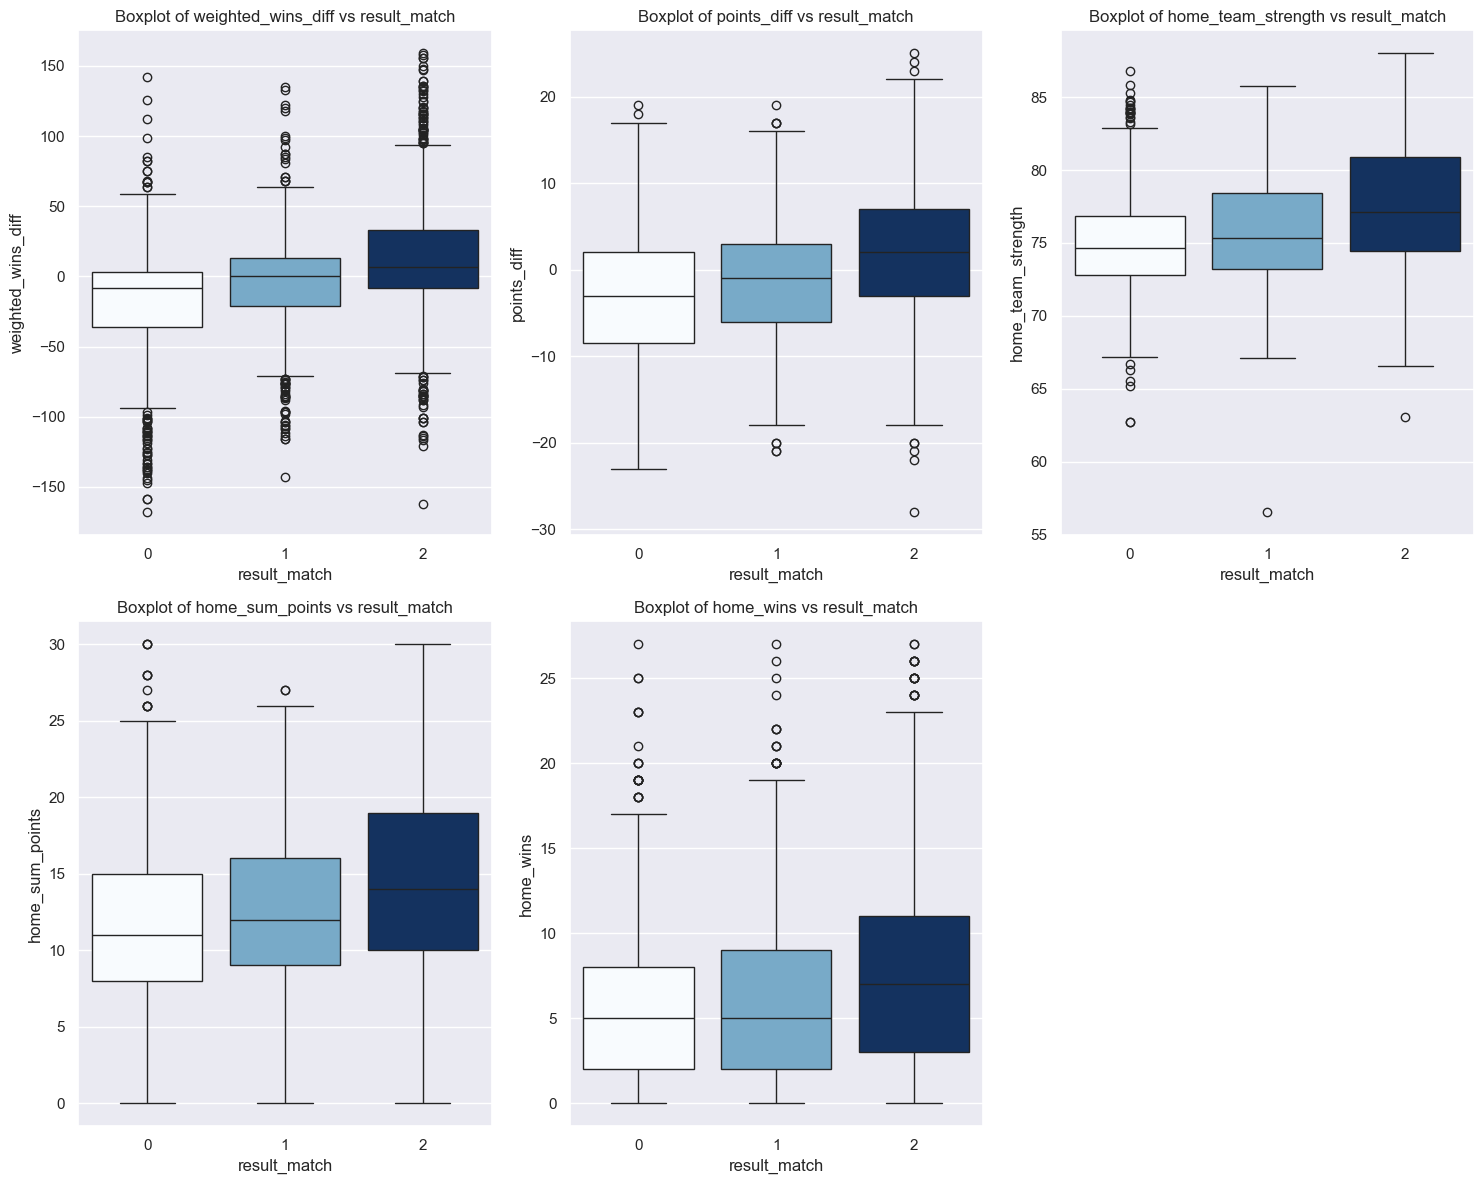

In [43]:
# Get top 5 positively and negatively correlated features
top_pos_correlated = correlation.index[1:6]  # Exclude the target variable itself
top_neg_correlated = correlation.index[-5:]

# Plotting the top 5 positively correlated features against result_match
plt.figure(figsize=(15, 12))
for i, feature in enumerate(top_pos_correlated, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x="result_match", y=feature, data=selected_df, palette="Blues", hue='result_match', legend=False)
    plt.title(f"Boxplot of {feature} vs result_match")

plt.tight_layout()
plt.show()

In [ ]:
# - weigthed_wins_diff:
# For result_match = 0: The median is negative, indicating that the away team typically has a higher weighted win score than the home team for this result category (possibly an away win).
# For result_match = 1: The distribution is more centered around zero, but still slightly skewed towards positive values.
# For result_match = 2: The median value is positive, suggesting that the home team generally has a higher weighted win score compared to the away team (possibly a home win).

# - points_diff: 
# For result_match = 0: The median points_diff is negative, indicating that the away team typically has more points than the home team when the match result is 0 (possibly an away win).
# For result_match = 1: The points_diff is centered around zerosuggesting that both teams are relatively evenly matched in terms of points when the result is a draw, but still slightly skewed towards negative values.
# For result_match = 2: The median points_diff is positive, indicating that the home team generally has more points than the away team when the match result is 2 (possibly a home win).

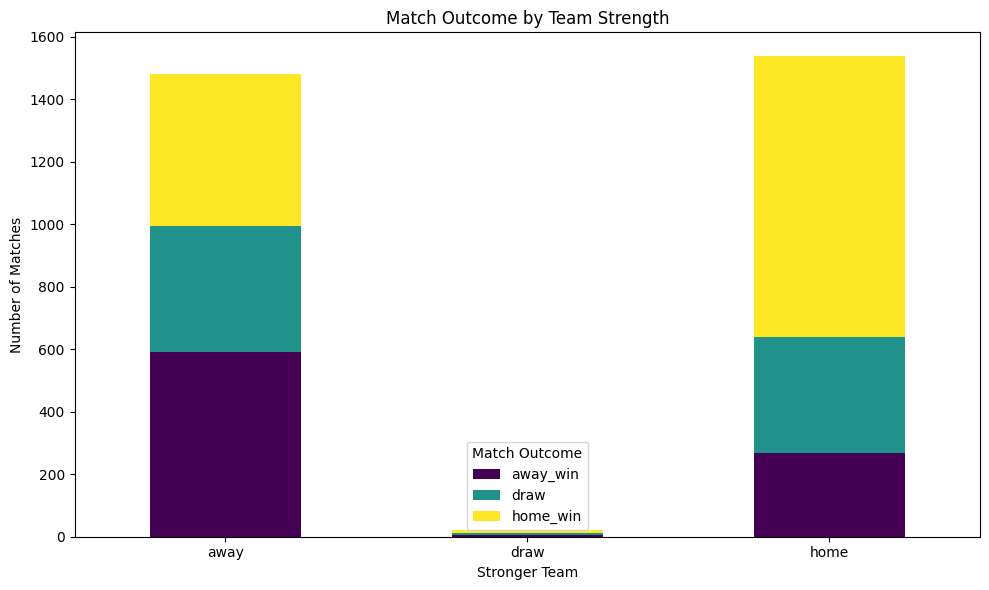

In [14]:
# 1. Match Outcome by Team Strength

# Creating a new column to indicate which team has higher strength
data['stronger_team'] = 'draw'
data.loc[data['home_team_strength'] > data['away_team_strength'], 'stronger_team'] = 'home'
data.loc[data['home_team_strength'] < data['away_team_strength'], 'stronger_team'] = 'away'

# Mapping result_match to outcomes
outcomes = {0: 'away_win', 1: 'draw', 2: 'home_win'}
data['match_outcome'] = data['result_match'].map(outcomes)

# Counting outcomes based on which team was stronger
strength_outcome = data.groupby(['stronger_team', 'match_outcome']).size().unstack()

strength_outcome.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Match Outcome by Team Strength')
plt.xlabel('Stronger Team')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Teams deemed "stronger" (either the home or away team) tend to win more often,
# as evidenced by the larger segments for "home_win" and "away_win" respectively.
strength_outcome

In [ ]:
# 2. Effect of Streaks

# Filtering matches where home or away teams are on a streak (considering 3 or more consecutive wins as a streak)
streak_threshold = 3
streak_data = data[data['home_streak_wins'] >= streak_threshold]

# Counting outcomes based on streaks
streak_outcomes = streak_data.groupby(['match_outcome']).size()

streak_outcomes

In [ ]:
streak_outcomes.plot(kind='pie', figsize=(8, 6), colormap='Set3', autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('Match Outcomes when a home team is on a Streak')
plt.ylabel('')  # Removing the default ylabel
plt.tight_layout()
plt.show()

In [ ]:
# 3. Effect of Possession

# Creating bins for possession
bins = [0, 40, 50, 60, 100]
labels = ['<40%', '40-50%', '50-60%', '>60%']
data['possession_bins'] = pd.cut(data['home_possession'], bins=bins, labels=labels, right=False)

# Counting outcomes based on possession bins
possession_outcomes = data.groupby(['possession_bins', 'match_outcome']).size().unstack()

possession_outcomes

In [ ]:
# 3. Visualization for Effect of Possession

possession_outcomes.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Match Outcomes based on Home Team Possession')
plt.xlabel('Home Team Possession Percentage')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# 4. Feature Interactions

# Categorizing shots on target
data['high_shots_home'] = (data['home_shoton'] > data['home_shoton'].median()).astype(int)

# Counting outcomes based on high possession (>60%) and high shots on target (above median)
interaction_outcomes = data[data['home_possession'] > 60].groupby(['high_shots_home', 'match_outcome']).size().unstack()

interaction_outcomes

In [ ]:
# 4. Visualization for Feature Interactions

interaction_outcomes.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Match Outcomes based on High Possession and Shots on Target')
plt.xlabel('High Shots on Target (Above Median)')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0)
plt.tight_layout()
plt.show()

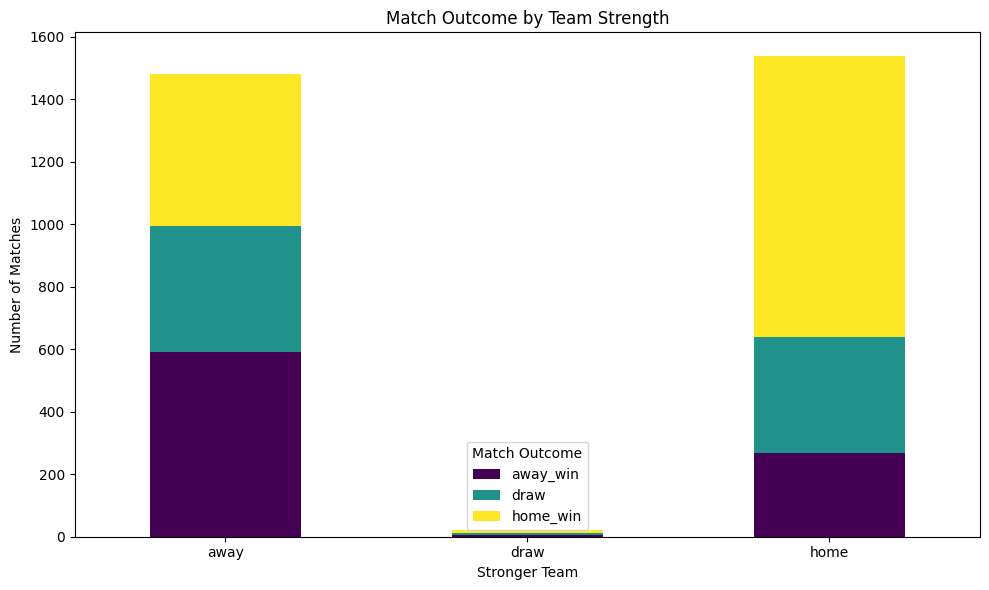

In [19]:
# 1. Match Outcome by Team Strength

# Creating a new column to indicate which team has higher strength
data['stronger_team'] = 'draw'
data.loc[data['home_team_strength'] > data['away_team_strength'], 'stronger_team'] = 'home'
data.loc[data['home_team_strength'] < data['away_team_strength'], 'stronger_team'] = 'away'

# Mapping result_match to outcomes
outcomes = {0: 'away_win', 1: 'draw', 2: 'home_win'}
data['match_outcome'] = data['result_match'].map(outcomes)

# Counting outcomes based on which team was stronger
strength_outcome = data.groupby(['stronger_team', 'match_outcome']).size().unstack()

strength_outcome.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Match Outcome by Team Strength')
plt.xlabel('Stronger Team')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [20]:
# Teams deemed "stronger" (either the home or away team) tend to win more often,
# as evidenced by the larger segments for "home_win" and "away_win" respectively.
strength_outcome

match_outcome,away_win,draw,home_win
stronger_team,,,
away,591,405,484
draw,7,6,9
home,269,372,897


In [37]:
# 2. Effect of Streaks

# Filtering matches where home or away teams are on a streak (considering 3 or more consecutive wins as a streak)
streak_threshold = 3
streak_data = data[data['home_streak_wins'] >= streak_threshold]

# Counting outcomes based on streaks
streak_outcomes = streak_data.groupby(['match_outcome']).size()

streak_outcomes

match_outcome
away_win     41
draw         28
home_win    121
dtype: int64

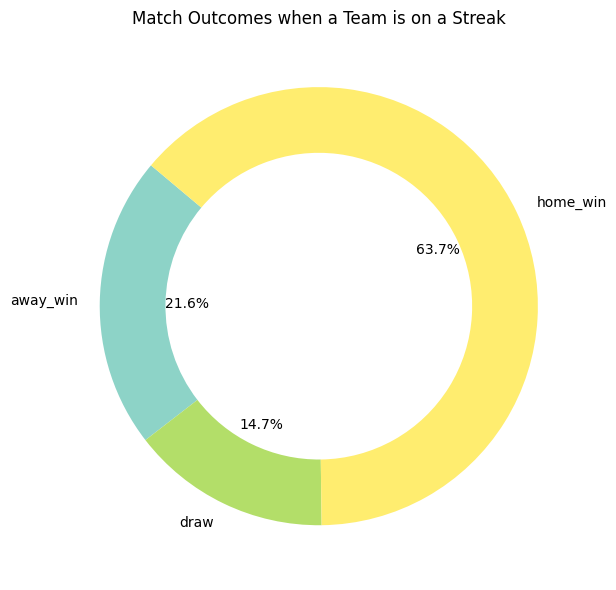

In [34]:
streak_outcomes.plot(kind='pie', figsize=(8, 6), colormap='Set3', autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('Match Outcomes when a home team is on a Streak')
plt.ylabel('')  # Removing the default ylabel
plt.tight_layout()
plt.show()

In [38]:
# 3. Effect of Possession

# Creating bins for possession
bins = [0, 40, 50, 60, 100]
labels = ['<40%', '40-50%', '50-60%', '>60%']
data['possession_bins'] = pd.cut(data['home_possession'], bins=bins, labels=labels, right=False)

# Counting outcomes based on possession bins
possession_outcomes = data.groupby(['possession_bins', 'match_outcome']).size().unstack()

possession_outcomes

C:\Users\kamil\AppData\Local\Temp\ipykernel_6236\1327691340.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  possession_outcomes = data.groupby(['possession_bins', 'match_outcome']).size().unstack()


match_outcome,away_win,draw,home_win
possession_bins,,,
<40%,54,60,142
40-50%,269,245,444
50-60%,365,347,582
>60%,179,131,222


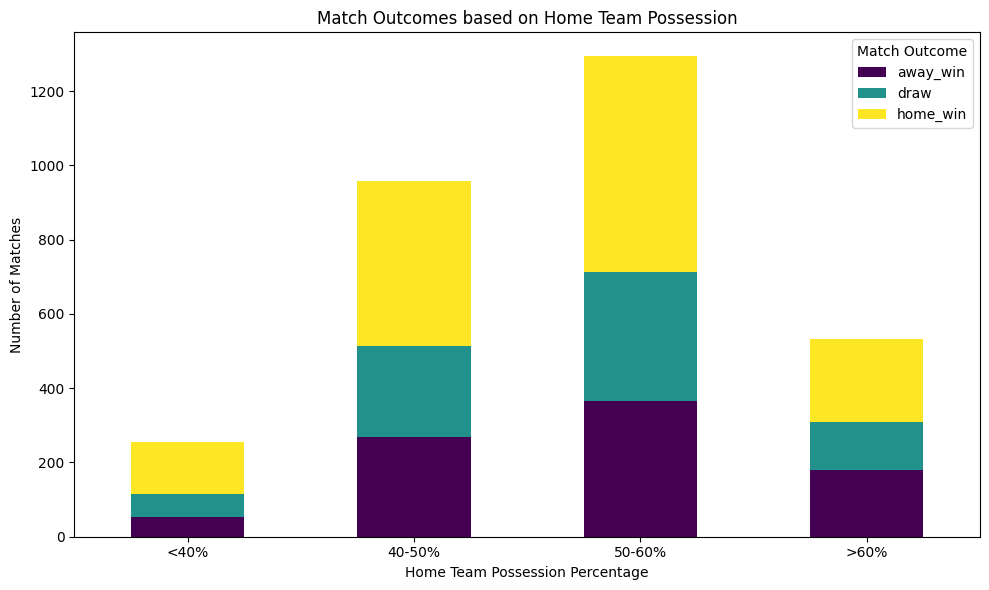

In [39]:
# 3. Visualization for Effect of Possession

possession_outcomes.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Match Outcomes based on Home Team Possession')
plt.xlabel('Home Team Possession Percentage')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [40]:
# 4. Feature Interactions

# Categorizing shots on target
data['high_shots_home'] = (data['home_shoton'] > data['home_shoton'].median()).astype(int)

# Counting outcomes based on high possession (>60%) and high shots on target (above median)
interaction_outcomes = data[data['home_possession'] > 60].groupby(['high_shots_home', 'match_outcome']).size().unstack()

interaction_outcomes

match_outcome,away_win,draw,home_win
high_shots_home,,,
0,101,76,110
1,40,36,64


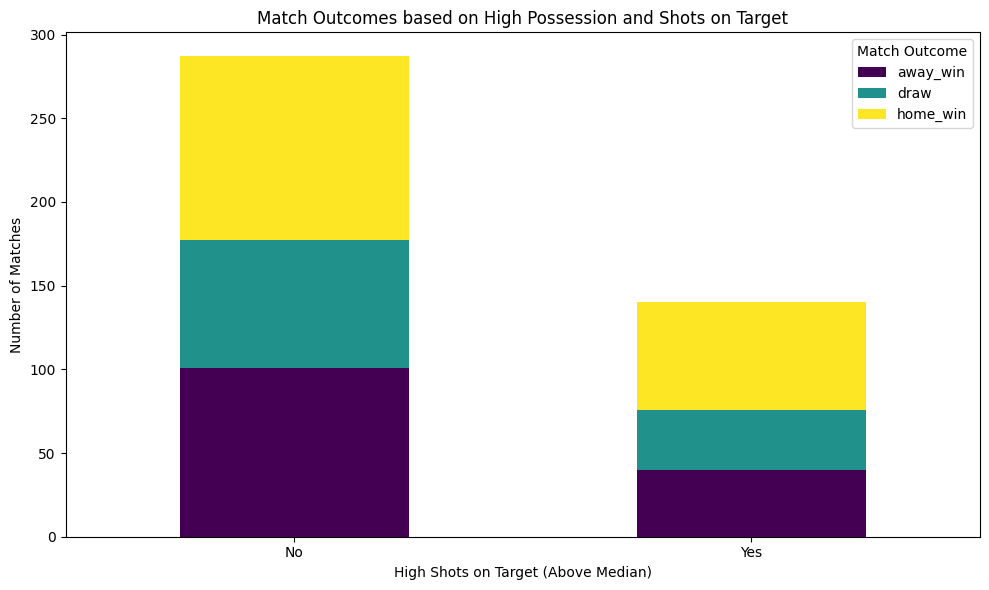

In [41]:
# 4. Visualization for Feature Interactions

interaction_outcomes.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Match Outcomes based on High Possession and Shots on Target')
plt.xlabel('High Shots on Target (Above Median)')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0)
plt.tight_layout()
plt.show()